In [24]:
from models.base_network import BaseNetwork
from file_handling.load_datasets import load_mnist
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.utils

import numpy as np
from copy import deepcopy

import matplotlib.pyplot as plt

from preprocessing.noise_models import gaussian_noise, shot_noise, defocus_blur, zoom_blur, brightness, snow, clipped_zoom

### Loading Datasets

In [6]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: 255*x)])
test_data = datasets.CIFAR10(root='./cifar-10', train=False, download=False, transform=transform)
train_data = datasets.CIFAR10(root='./cifar-10', train=True, download=False, transform=transform)

In [7]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1000, shuffle=False, num_workers=2)

### Initializing Networks

In [8]:
reg_net = BaseNetwork("reg_net", [(3, 16, 5),(16,32,5),(800,5000),(5000,100),(100,10)],
                                ["conv", "conv", "fc", "fc", "fc"])
# reg_net = BaseNetwork("reg_net", [(3, 16, 5),(16,32,5),(800,100),(100,10)],
#                                 ["conv", "conv", "fc", "fc"])
# reg_net = BaseNetwork("reg_net", [(3*1024,5000),(5000,100),(100,10)],
#                                 ["fc", "fc", "fc"])
reg_net_opt = optim.RMSprop(reg_net.parameters(), lr=0.0005)

In [9]:
emb_net = BaseNetwork("emb_net", [(3, 16, 5),(16,32,5), (800,5000),(5000,100),(100,10)],
                                ["conv", "conv", "emb", "fc", "fc"])
# emb_net = BaseNetwork("emb_net", [(3*1024,5000),(5000,100),(100,10)],
#                                 ["emb", "fc", "fc"])
emb_net_opt = optim.RMSprop(emb_net.parameters(), lr=0.00005, momentum=0.9)

In [10]:
criterion = nn.CrossEntropyLoss()

### Training, Saving and Loading Models

In [11]:
# reg_net.train_model(train_loader, 3, reg_net_opt, criterion)
# reg_net.save_model("saved_models/reg_net_test.pt")

In [12]:
# emb_net.train_model(train_loader, 3, emb_net_opt, criterion)
# emb_net.save_model("saved_models/emb_net_test.pt")

In [38]:
reg_net.load_model("saved_models/reg_net_test.pt")
emb_net.load_model("saved_models/emb_net_test.pt")

### Testing Pure Accuracy on Test Set

In [17]:
print("Test accuracy of REGULAR network with NO NOISE: {}".format(reg_net.test_model_once(test_loader, None, 0)))
print("Test accuracy of EMBEDDED network with NO NOISE: {}".format(emb_net.test_model_once(test_loader, None, 0)))

Evaluating model once
Test accuracy of REGULAR network with NO NOISE: 53.53
Evaluating model once
Test accuracy of EMBEDDED network with NO NOISE: 54.26


### Testing on Gaussian Noise

In [16]:
print("Test accuracy of REGULAR network on GAUSSIAN NOISE: {}".format(reg_net.test_model(test_loader, gaussian_noise)))
print("Test accuracy of EMBEDDED network on GAUSSIAN NOISE: {}".format(emb_net.test_model(test_loader, gaussian_noise)))

Evaluating model once
Evaluating model once
Evaluating model once
Evaluating model once
Evaluating model once
Test accuracy of REGULAR network on GAUSSIAN NOISE: [52.96, 51.09, 47.8, 45.52, 43.49]
Evaluating model once
Evaluating model once
Evaluating model once
Evaluating model once
Evaluating model once
Test accuracy of EMBEDDED network on GAUSSIAN NOISE: [53.55, 52.88, 51.74, 51.68, 50.89]


### Testing on Shot Noise

In [19]:
print("Test accuracy of REGULAR network on SHOT NOISE: {}".format(reg_net.test_model(test_loader, shot_noise)))
print("Test accuracy of EMBEDDED network on SHOT NOISE: {}".format(emb_net.test_model(test_loader, shot_noise)))

Evaluating model once
Evaluating model once
Evaluating model once
Evaluating model once
Evaluating model once
Test accuracy of REGULAR network on SHOT NOISE: [53.25, 53.26, 51.52, 49.64, 46.5]
Evaluating model once
Evaluating model once
Evaluating model once
Evaluating model once
Evaluating model once
Test accuracy of EMBEDDED network on SHOT NOISE: [54.0, 53.65, 52.45, 52.24, 51.19]


### Testing on Zoom Blur

In [20]:
print("Test accuracy of REGULAR network on ZOOM BLUR: {}".format(reg_net.test_model(test_loader, zoom_blur)))
print("Test accuracy of EMBEDDED network on ZOOM BLUR: {}".format(emb_net.test_model(test_loader, zoom_blur)))

Evaluating model once
Evaluating model once
Evaluating model once
Evaluating model once
Evaluating model once
Test accuracy of REGULAR network on ZOOM BLUR: [48.55, 47.54, 45.78, 44.41, 41.74]
Evaluating model once
Evaluating model once
Evaluating model once
Evaluating model once
Evaluating model once
Test accuracy of EMBEDDED network on ZOOM BLUR: [53.83, 53.64, 53.27, 52.7, 51.72]


### Inspecting Convolution Weights

In [21]:
weights_reg, bias_reg = deepcopy(reg_net.state_dict()['convs.0.weight']), deepcopy(reg_net.state_dict()['convs.0.bias'])
weights_emb, bias_emb = deepcopy(emb_net.state_dict()['convs.0.weight']), deepcopy(emb_net.state_dict()['convs.0.bias'])

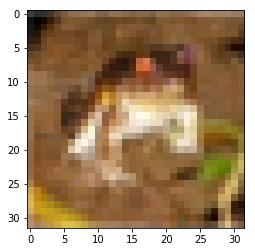

In [22]:
def norm(im):
    im = deepcopy(im)
    im = im - torch.min(im)
    im = im / torch.max(im)
    return im
plt.imshow(train_data[0][0].int().permute(1, 2 ,0))
plt.show()

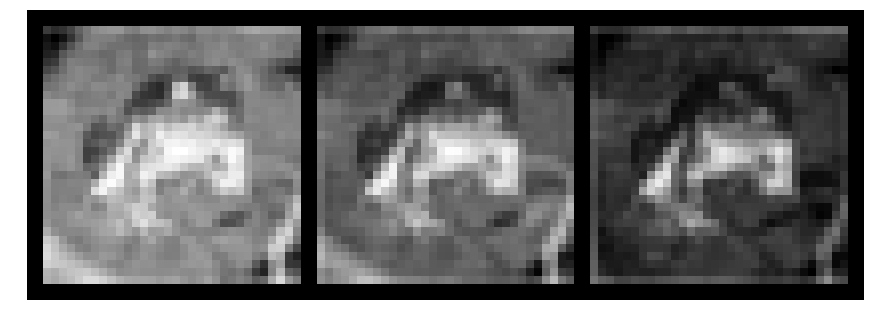

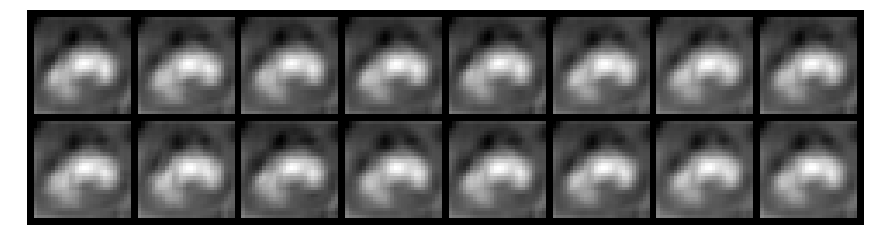

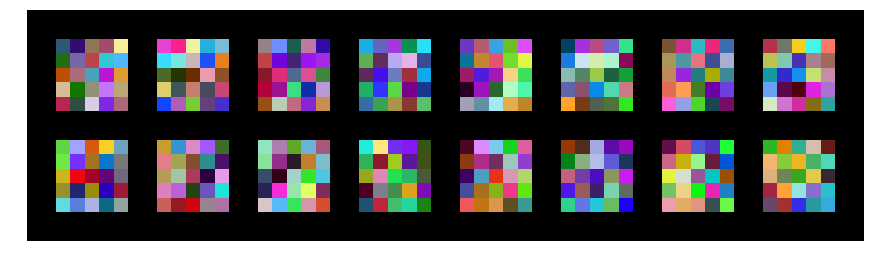

In [39]:
def imshow(img, to_norm=True, figsize=(15, 10)):
    img = deepcopy(img)
    if to_norm:
        img = norm(img)
    npimg = img.numpy()
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()
    
test_im,_ = train_data[0]
test_im = test_im[None,:,:,:]
test_im_reg = F.conv2d(test_im, weight=weights_reg, bias=bias_reg).permute(1,0,2,3)

for i in range(len(weights_reg)):
    weights_reg[i] = norm(weights_reg[i])
    test_im_reg[i] = norm(test_im_reg[i])

imshow(torchvision.utils.make_grid(train_data[0][0][:, None, :, :]))
imshow(torchvision.utils.make_grid(test_im_reg), to_norm=False)
imshow(torchvision.utils.make_grid(weights_reg), to_norm=False)




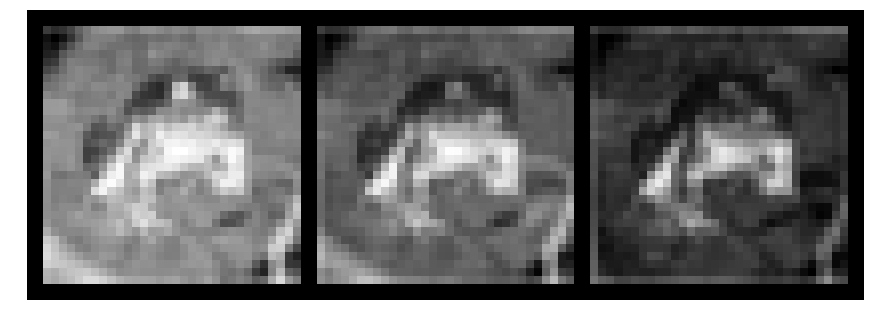

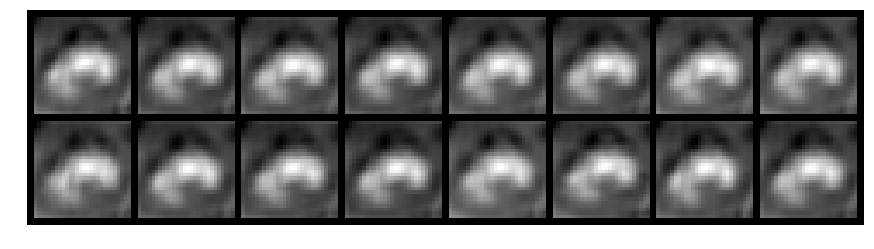

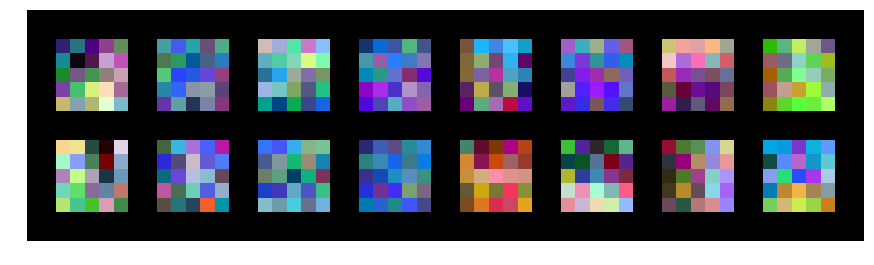

In [40]:
test_im_emb = F.conv2d(test_im, weight=weights_emb, bias=bias_emb).permute(1,0,2,3)

# print(test_im_reg)

for i in range(len(weights_emb)):
    weights_emb[i] = norm(weights_emb[i])
    test_im_emb[i] = norm(test_im_emb[i])

imshow(torchvision.utils.make_grid(train_data[0][0][:, None, :, :]))
imshow(torchvision.utils.make_grid(test_im_emb), to_norm=False)
imshow(torchvision.utils.make_grid(weights_emb), to_norm=False)